In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir = "/content/drive/MyDrive/Dataset/train"
validation_dir = "/content/drive/MyDrive/Dataset/val"

BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 188 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 47 files belonging to 2 classes.


In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 1


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

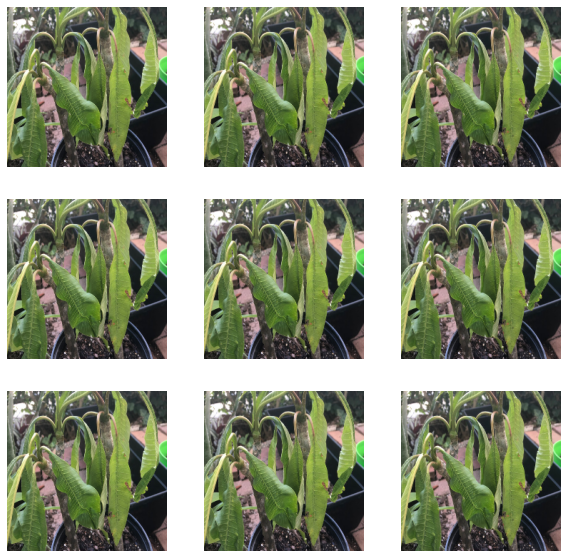

In [49]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.densenet.DenseNet201(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

74850304/74836368 [==============================] - 1s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1920)


## Feature extraction

### Freeze the convolutional base

In [15]:
base_model.trainable = False

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1920)


In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [19]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0     

In [22]:
len(model.trainable_variables)

2

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2/2 [==============================] - 22s 2s/step - loss: 0.7479 - accuracy: 0.4839


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.48


In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
12/12 [==============================] - 26s 763ms/step - loss: 0.7301 - accuracy: 0.4787 - val_loss: 0.7627 - val_accuracy: 0.3548
Epoch 2/10
12/12 [==============================] - 7s 329ms/step - loss: 0.7213 - accuracy: 0.4840 - val_loss: 0.6653 - val_accuracy: 0.4839
Epoch 3/10
12/12 [==============================] - 7s 332ms/step - loss: 0.7612 - accuracy: 0.4309 - val_loss: 0.6518 - val_accuracy: 0.5161
Epoch 4/10
12/12 [==============================] - 7s 335ms/step - loss: 0.7027 - accuracy: 0.5319 - val_loss: 0.7088 - val_accuracy: 0.3871
Epoch 5/10
12/12 [==============================] - 7s 331ms/step - loss: 0.6914 - accuracy: 0.5426 - val_loss: 0.6427 - val_accuracy: 0.4516
Epoch 6/10
12/12 [==============================] - 7s 327ms/step - loss: 0.7048 - accuracy: 0.5106 - val_loss: 0.6920 - val_accuracy: 0.4516
Epoch 7/10
12/12 [==============================] - 7s 327ms/step - loss: 0.6602 - accuracy: 0.5532 - val_loss: 0.6836 - val_accuracy: 0.5484
Epoch

### Learning curves



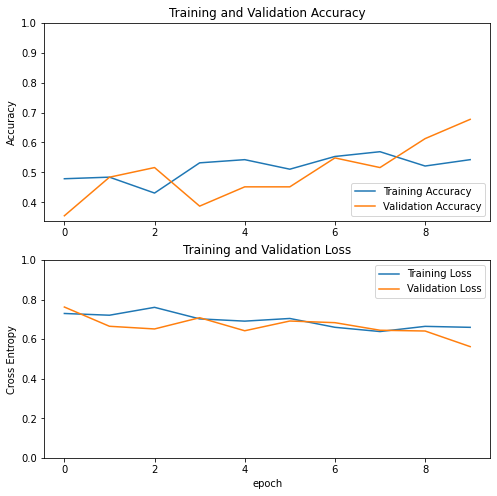

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig("Initial_10_epoch.png")

## Fine tuning

### Un-freeze the top layers of the model


In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  707


### Compile the model

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0     

In [31]:
len(model.trainable_variables)

179

### Continue training the model

In [32]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/30
12/12 [==============================] - 35s 819ms/step - loss: 0.5395 - accuracy: 0.6755 - val_loss: 0.4428 - val_accuracy: 0.8710
Epoch 11/30
12/12 [==============================] - 8s 389ms/step - loss: 0.3894 - accuracy: 0.8138 - val_loss: 0.3827 - val_accuracy: 0.8710
Epoch 12/30
12/12 [==============================] - 7s 384ms/step - loss: 0.3045 - accuracy: 0.8564 - val_loss: 0.3050 - val_accuracy: 0.9355
Epoch 13/30
12/12 [==============================] - 7s 380ms/step - loss: 0.2748 - accuracy: 0.8989 - val_loss: 0.2560 - val_accuracy: 0.8387
Epoch 14/30
12/12 [==============================] - 8s 386ms/step - loss: 0.2097 - accuracy: 0.9202 - val_loss: 0.2454 - val_accuracy: 0.9677
Epoch 15/30
12/12 [==============================] - 7s 382ms/step - loss: 0.1951 - accuracy: 0.9362 - val_loss: 0.1591 - val_accuracy: 0.9677
Epoch 16/30
12/12 [==============================] - 7s 382ms/step - loss: 0.1795 - accuracy: 0.9309 - val_loss: 0.2041 - val_accuracy: 0.967

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [35]:
print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.478723406791687, 0.48404255509376526, 0.4308510720729828, 0.5319148898124695, 0.542553186416626, 0.5106382966041565, 0.5531914830207825, 0.5691489577293396, 0.521276593208313, 0.542553186416626, 0.6755319237709045, 0.813829779624939, 0.8563829660415649, 0.8989361524581909, 0.9202127456665039, 0.936170220375061, 0.9308510422706604, 0.957446813583374, 0.9680851101875305, 0.9627659320831299, 0.978723406791687, 0.9680851101875305, 0.9946808218955994, 0.9680851101875305, 0.9680851101875305, 0.9946808218955994, 0.9893617033958435, 0.9680851101875305, 0.9893617033958435, 1.0, 0.9946808218955994]
[0.35483869910240173, 0.4838709533214569, 0.5161290168762207, 0.3870967626571655, 0.4516128897666931, 0.4516128897666931, 0.5483871102333069, 0.5161290168762207, 0.6129032373428345, 0.6774193644523621, 0.8709677457809448, 0.8709677457809448, 0.9354838728904724, 0.8387096524238586, 0.9677419066429138, 0.9677419066429138, 0.9677419066429138, 0.9677419066429138, 1.0, 0.9677419066429138, 0.967741906642

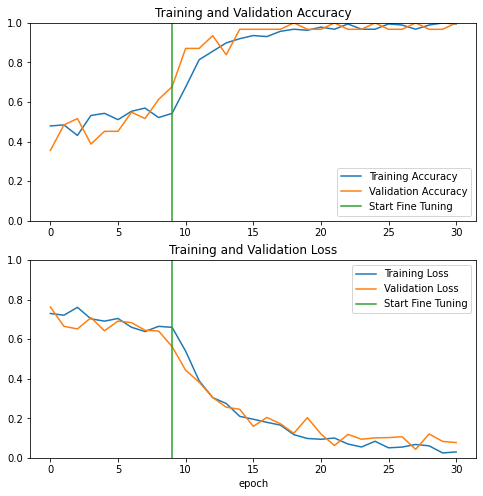

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig("Final_plot.png")

In [37]:
# model.save("mobilenet1.h5")

### Evaluation and prediction

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 960ms/step - loss: 0.0623 - accuracy: 1.0000
Test accuracy : 1.0


In [39]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

Predictions:
 [0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0]
Labels:
 [0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0]


In [40]:
from sklearn import metrics

In [41]:
print("accuracy : ",metrics.accuracy_score(label_batch,predictions,normalize=True))
print('Confusion Matrix')
cm = metrics.confusion_matrix(label_batch, predictions)
print(cm)
print('Classification Report')
print(metrics.classification_report(label_batch, predictions))

accuracy :  1.0
Confusion Matrix
[[9 0]
 [0 7]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         7

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

